In [3]:
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
poly = np.polynomial.Polynomial

from astropy.io import ascii

from scipy.integrate import quad
from scipy.integrate import trapz
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.misc import derivative
from scipy.optimize import curve_fit

In [4]:
stratologger = ascii.read("OY2Stratologger.txt", data_start = 15)
fsORSim = ascii.read("OY2Perf.csv", data_start = 1)
fsORSimDayOf = ascii.read("OY2Wind.csv", data_start = 1)

In [5]:
stratologger
#fsORSimDayOf

col1,col2,col3,col4,col5
float64,int32,int32,float64,float64
0.0,1,0,85.35,9.5
0.05,1,7,85.37,9.5
0.1,2,-3,85.35,9.5
0.15,1,4,85.37,9.5
0.2,1,3,85.39,9.5
0.25,2,4,85.39,9.5
0.3,2,7,85.39,9.5
0.35,2,11,85.39,9.5
0.4,3,16,85.35,9.5


In [371]:
t = stratologger["col1"]
y = stratologger["col2"]
v = stratologger["col3"]
temp = stratologger["col4"]
volt = stratologger["col5"]
orWt = fsORSimDayOf["Time"]
orWy = fsORSimDayOf["Altitude"]
orWy = [x*3.2808 for x in orWy]
orWv = fsORSimDayOf["Vertical velocity"]
orWv = [x*3.2808 for x in orWv]
orWa = fsORSimDayOf["Vertical acceleration"]
orWa = [x*3.2808 for x in orWa]
ort = fsORSimDayOf["Time"]
orv = fsORSimDayOf["Vertical velocity"]
orv = [x*3.2808 for x in orv]
ora = fsORSimDayOf["Vertical acceleration"]
ora = [x*3.2808 for x in ora]
ory = fsORSimDayOf["Altitude"]
ory = [x*3.2808 for x in ory]

# Data Plots

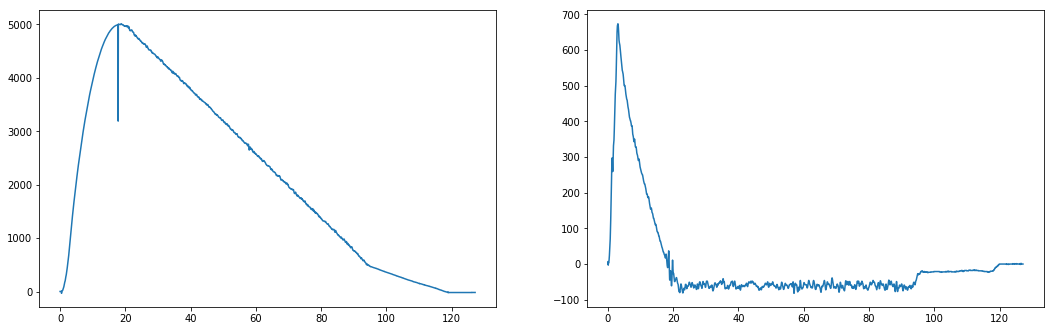

In [5]:
#base data plot
figure(figsize = (18, 12))

subplot(221)
plot(t, y)

subplot(222)
plot(t, v)

show()

In [6]:
# "smooth" altitude by determining difference between adjacent values and changing it if its within a certain value
# called numerically smoothed values in future references
        
yAlt = [x for x in y] #re-make yAlt so you dont compound adjustments
for x in range(1, len(yAlt)):
    if abs(yAlt[x] - yAlt[x-1]) > 40: #40 is minimum difference to maintain accuracy and relative "smoothness"
        yAlt[x] = yAlt[x-1]

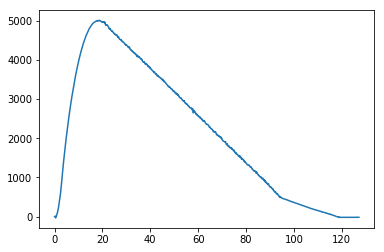

In [7]:
plot(t, yAlt)

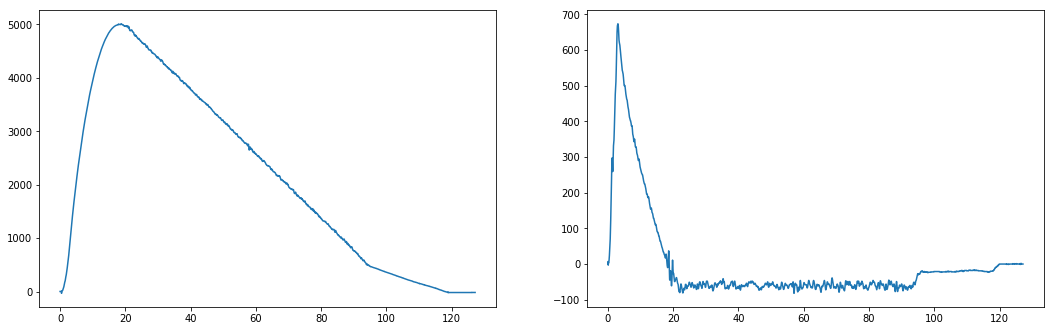

In [8]:
#base data plot
figure(figsize = (18, 12))

subplot(221)
plot(t, yAlt)

subplot(222)
plot(t, v)

show()

In [9]:
maxVel = max(v)
maxAlt = max(yAlt)

In [10]:
apogeeIndex = yAlt.index(maxAlt)
tList = []
vList = []
for x in range(0, len(t)): tList.append(t[x])
mainIndex = tList.index(95.00)
landIndex = tList.index(120.00)
print apogeeIndex
print mainIndex
print landIndex

375
1900
2400


In [11]:
drogueAvgDecent = 0
for x in range(apogeeIndex, mainIndex): drogueAvgDecent += v[x]
drogueAvgDecent /= (mainIndex - apogeeIndex)
drogueAvgDecent *= -1
print drogueAvgDecent

60


In [12]:
mainAvgDecent = 0
for x in range(mainIndex, landIndex): mainAvgDecent += v[x]
mainAvgDecent /= (landIndex - mainIndex)
mainAvgDecent *= -1
print mainAvgDecent

20


In [20]:
slAccel = [0.0] + [dx / dt for dx, dt in zip(diff(v), diff(t))]

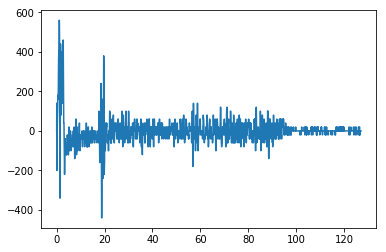

In [21]:
plot(t, slAccel)

In [59]:
aSmooth = gaussian_filter1d(slAccel, 10)

aAdj = [x for x in slAccel]
for x in range(1, len(aAdj)):
    if abs(aAdj[x] - aAdj[x-1]) > 110: #5 is minimum difference to maintain accuracy and relative "smoothness"
        aAdj[x] = aAdj[x-1]
        
aASmooth = gaussian_filter1d(aAdj, 5)

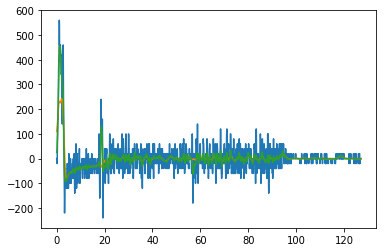

In [71]:
plot(t, aAdj)
plot(t, aSmooth)
plot(t, aASmooth)

maxAccel = int(max(aASmooth))

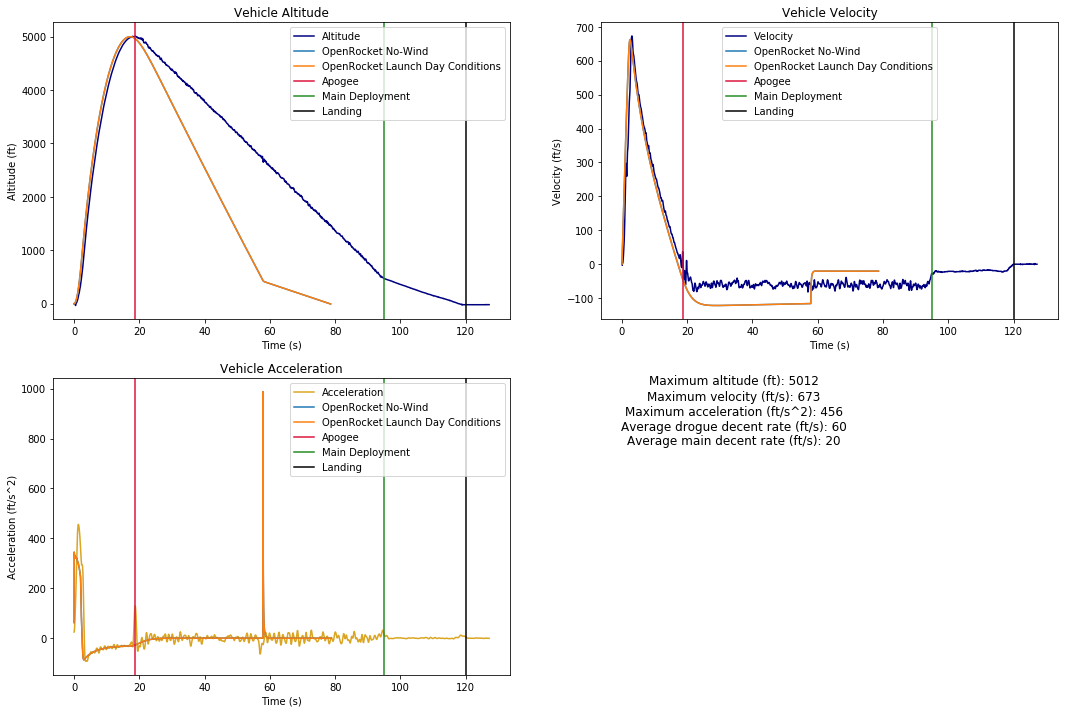

In [375]:
#base data plot
figure(figsize = (18, 12))

subplot(221)
plot(t, yAlt, c = "navy", label = "Altitude")
plot(ort, ory, label = "OpenRocket No-Wind")
plot(orWt, orWy, label = "OpenRocket Launch Day Conditions")
axvline(x=t[apogeeIndex], c = "crimson", label = "Apogee")
axvline(x=t[mainIndex], c = "forestgreen", label = "Main Deployment")
axvline(x=t[landIndex], c = "black", label = "Landing")
#hlines(y=600,xmin=0, xmax=200)
legend()
xlabel("Time (s)")
ylabel("Altitude (ft)")
title("Vehicle Altitude")

subplot(222)
plot(t, v, c = "navy", label = "Velocity")
plot(ort, orv, label = "OpenRocket No-Wind")
plot(orWt, orWv, label = "OpenRocket Launch Day Conditions")
axvline(x=t[apogeeIndex], c = "crimson", label = "Apogee")
axvline(x=t[mainIndex], c = "forestgreen", label = "Main Deployment")
axvline(x=t[landIndex], c = "black", label = "Landing")
legend()
xlabel("Time (s)")
ylabel("Velocity (ft/s)")
title("Vehicle Velocity")

subplot(223)
plot(t, aASmooth, c = "goldenrod", label = "Acceleration")
plot(ort, ora, label = "OpenRocket No-Wind")
plot(orWt, orWa, label = "OpenRocket Launch Day Conditions")
axvline(x=t[apogeeIndex], c = "crimson", label = "Apogee")
axvline(x=t[mainIndex], c = "forestgreen", label = "Main Deployment")
axvline(x=t[landIndex], c = "black", label = "Landing")
legend()
xlabel("Time (s)")
ylabel("Acceleration (ft/s^2)")
title("Vehicle Acceleration")

sa = 'Maximum altitude (ft): ' + str(maxAlt)
sv = "Maximum velocity (ft/s): " + str(maxVel)
sac = "Maximum acceleration (ft/s^2): " + str(maxAccel)
svad = "Average drogue decent rate (ft/s): " + str(drogueAvgDecent)
svam = "Average main decent rate (ft/s): " + str(mainAvgDecent)
s = sa + "\n" + sv + "\n" + sac + "\n" + svad + "\n" + svam
figtext(.65, .43, s, fontsize = "large", horizontalalignment = "center", verticalalignment = "center")

savefig("oy2everything.png")

show()



In [274]:
accelList = [x for x in aASmooth]
iMinA = accelList.index(min(accelList))
tMinA = t[iMinA]
coastTime = t[apogeeIndex] - tMinA
accelCoast = accelList[iMinA:apogeeIndex-11]
tCoast = t[iMinA:apogeeIndex-11]
vCoast = v[iMinA:apogeeIndex-11]

mass = 9.443 #kg

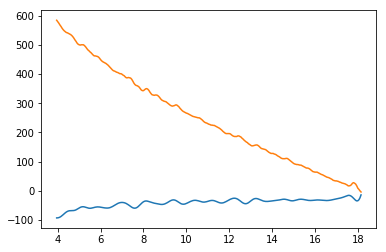

In [168]:
plot(tCoast, accelCoast)
plot(tCoast, vCoast)

In [297]:
acM = [x/3.2808 for x in accelCoast]
vCoastM = [x/3.2808 for x in vCoast]

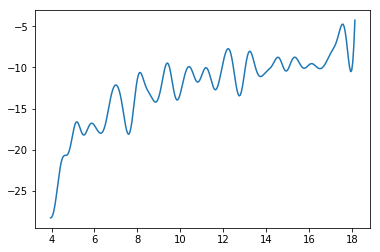

In [103]:
plot(tCoast, acM)

In [143]:
aFunc = interp1d(tCoast, acM)
print type(aFunc)

<class 'scipy.interpolate.interpolate.interp1d'>


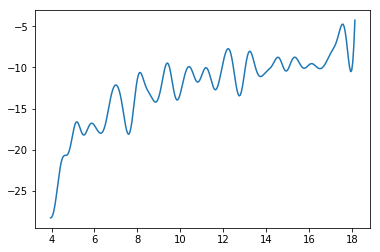

In [111]:
plot(tCoast, aFunc(tCoast))

In [152]:
# popt, popv = curve_fit(aFunc, tCoast, yVals)
poly = polyfit(tCoast, acM, deg = 15)
p = poly1d(poly)

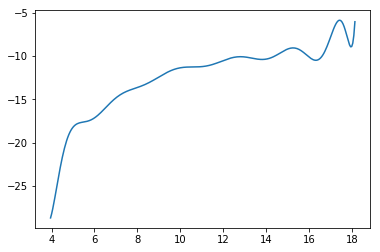

In [153]:
plot(tCoast, p(tCoast))

In [277]:
def dragF(m, a, t):
    return -1*m*a(t)

In [330]:
dragf = dragF(mass, p, tCoast)
dragff = dragF(mass, aFunc, tCoast)

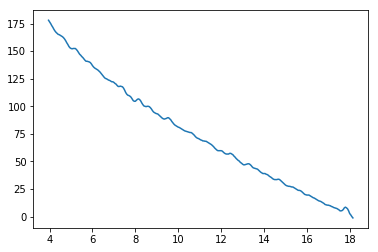

In [331]:
plot(tCoast, vCoastM)

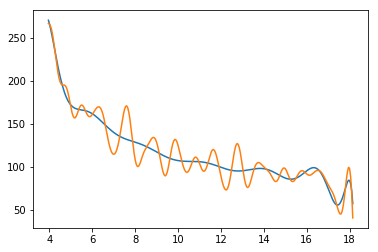

In [332]:
plot(tCoast, dragf)
plot(tCoast, dragff)

In [345]:
A = (2.75**2 * pi + 5) * (0.0254)**2
fGrav = mass*-9.8
rho = 1.15 
cd = []
cdf = []
for i in range(0, len(dragf)):
    cd.append(((2*(dragf[i]+fGrav))/(A*rho*(vCoastM[i]**2))))
    cdf.append(((2*(dragff[i]+fGrav))/(A*rho*(vCoastM[i]**2))))
    
slowVelCutoff = 200
cd = cd[0:-slowVelCutoff]
cdf = cdf[0:-slowVelCutoff]

c:\python27\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
c:\python27\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


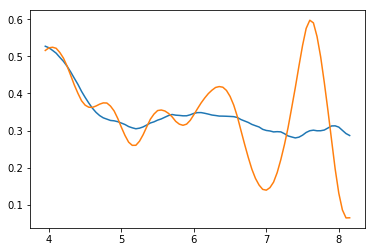

In [346]:
plot(tCoast[0:-slowVelCutoff], cd)
plot(tCoast[0:-slowVelCutoff], cdf)

In [347]:
cdtot = 0
cdftot = 0
for x in cd: cdtot+=x
for x in cdf: cdftot += x
cdfavg = cdftot/len(cdf)
cdavg = cdtot/len(cd)
print cdavg
print cdfavg

0.3414078642665853
0.34397085744622863
